In [2]:
def get_pt_from_fname(filepath):
    """
    Extract patient ID from filename.
    
    Args:
    - filepath (str): Path to the file.
    
    Returns:
    - patient_id (str): Extracted patient ID.
    """
    # Extract the filename without extension
    import os
    import scipy.io
    import numpy as np

    filename = os.path.basename(filepath)
    
    # Assuming the patient ID is the second part of the filename, split by '_'
    parts = filename.split('_')
    
    if len(parts) > 1:
        patient_id = parts[1]  # Extracts '0284' from 'ICARE_0284_05'
    else:
        raise ValueError("Filename format is incorrect.")
    
    return patient_id


In [3]:
import wfdb

def extract_header(filename):
    record = wfdb.rdheader("0284_005_008_EEG")
    fs = record.fs
    channel = record.sig_name
    return fs, channel

In [4]:
def save_eeg_data(eeg_data, save_path):
    """
    Saves EEG data to a file.
    
    Args:
    - eeg_data (np.array): Processed EEG data.
    - save_path (str): Path to save the data.
    """
    import numpy as np
    
    np.save(save_path, eeg_data)


In [5]:
def reorder_eeg_channels(eeg_data, channel_names):
    import numpy as np

    desired_channel_order = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                             'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']

    mapping_dict = {}
    reordered_channels_data = []

    patient_eeg = eeg_data  # Shape: [n_channels, n_samples]
    patient_channels = channel_names  # List or array of channel names

    n_samples = patient_eeg.shape[1]  # Number of samples per channel

    for channel in desired_channel_order:
        if channel in patient_channels:
            index = patient_channels.index(channel)
            mapping_dict[channel] = index
            channel_data = patient_eeg[index]  # Extract the channel data
            reordered_channels_data.append(channel_data)
        else:
            # If the desired channel is not present, fill with zeros
            mapping_dict[channel] = None
            channel_data = np.zeros(n_samples)
            reordered_channels_data.append(channel_data)
            print(str(channel) + " is missing, so it was padded with zeros")

    # Convert the list to a NumPy array
    reordered_eeg_data = np.array(reordered_channels_data)

    return reordered_eeg_data, mapping_dict


In [15]:
import numpy as np
from scipy.signal import resample
import resampy

def standardize_struct(input_data, fs, channel):
    """
    Standardize EEG data structure by unifying channel nomenclature, reordering channels, and downsampling.
    
    Args:
    - input_data (dict): Input EEG data in a dictionary format with keys 'header' and 'matrix'.
    
    Returns:
    - output (dict): Standardized EEG data structure.
    """

    # Constants
    FREQUENCY = fs  # Assumes same frequency for all channels
    N_CHANNELS = 19  # Final number of channels
    TARGET_FREQUENCY = 200  # Target frequency for downsampling

    # Unify nomenclature and reorder channels
    # Assuming `map_channels` is a function that maps input channels to the standard ones
    reordered_eeg, channel_mapping = reorder_eeg_channels(input_data, channel)  # Get channel mapping
    num_chans = len(input_data)

    
    # output = {
    #     'header': {
    #         'ns': N_CHANNELS,
    #         'label': ['Fp1', 'Fp2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'Fz', 'Cz', 'Pz'],
    #         'transducer': [None] * N_CHANNELS,
    #         'units': [None] * N_CHANNELS,
    #         'physicalMin': np.zeros(N_CHANNELS),
    #         'physicalMax': np.zeros(N_CHANNELS),
    #         'digitalMin': np.zeros(N_CHANNELS),
    #         'digitalMax': np.zeros(N_CHANNELS),
    #         'prefilter': [None] * N_CHANNELS,
    #         'frequency': [TARGET_FREQUENCY] * N_CHANNELS
    #     },
    #     'matrix': np.zeros((N_CHANNELS, resample(input_data['matrix'][0], TARGET_FREQUENCY, FREQUENCY).shape[0]))
    # }

    # #Downsampling and reordering is done below
    # for k in range(num_chans):
    #     if not np.isnan(s_to_m[k]):  #Checks for mapping to current channel
    #         #Downsamples
    #         output['matrix'][s_to_m[k]] = resample(input_data['matrix'][k], TARGET_FREQUENCY, FREQUENCY)

    #         #Copy header info for each mapped channel
    #         output['header']['transducer'][s_to_m[k]] = input_data['header']['transducer'][k]
    #         output['header']['units'][s_to_m[k]] = input_data['header']['units'][k]
    #         output['header']['physicalMin'][s_to_m[k]] = input_data['header']['physicalMin'][k]
    #         output['header']['physicalMax'][s_to_m[k]] = input_data['header']['physicalMax'][k]
    #         output['header']['digitalMin'][s_to_m[k]] = input_data['header']['digitalMin'][k]
    #         output['header']['digitalMax'][s_to_m[k]] = input_data['header']['digitalMax'][k]
    #         output['header']['prefilter'][s_to_m[k]] = input_data['header']['prefilter'][k]

    output = resampy.resample(reordered_eeg, TARGET_FREQUENCY, FREQUENCY)

    return output, channel_mapping

In [12]:
import os
import numpy as np
import scipy.io

def load_mat_eeg(fs, channel_order, filepath, use_saved=True, save_result=True):
    """
    Load EEG data from .mat files, process it, and optionally save/load intermediate results.
    
    Args:
    - filepath (str): Path to the .mat file.
    - use_saved (bool): If True, loads a saved processed EEG file if it exists.
    - save_result (bool): If True, saves the processed EEG data to a .npy file.
    
    Returns:
    - eeg_data (np.array): Processed EEG data.
    """
    filename_no_ext, ext = os.path.splitext(filepath)
    patient_id = get_pt_from_fname(filepath)  # Adjust as per your function to extract '0284'

    eeglab_save_folder = os.path.join('output_dir', 'eeglab', patient_id)
    eeglab_save_path = os.path.join(eeglab_save_folder, f"{filename_no_ext}_eeglab.npy")
    
    if not os.path.exists(eeglab_save_folder):
        os.makedirs(eeglab_save_folder)

    #Load saved EEG data if it exists
    if use_saved and os.path.exists(eeglab_save_path):
        print("EEGLAB file already exists, loading...")
        eeg_data = np.load(eeglab_save_path)
        if check_loaded_eeglab(eeg_data):  #Checks if the loaded data is valid
            return eeg_data
    

    print(f"Processing .mat file from {filepath}")
    eeg_struct = scipy.io.loadmat(filepath)
    eeg_data = eeg_struct.get('val', None)  
    
    # if eeg_data is None:
    #     raise ValueError("EEG data not found in the .mat file.")
    
    # Standardize the EEG structure (if you have custom logic for standardization)
    eeg_data, channel_mapping = standardize_struct(eeg_data, fs, channel_order)
    
    print(channel_mapping)
    # Save the result if save_result is True
    if save_result:
        print(f"Saving processed EEG data to {eeglab_save_path}")
        np.save(eeglab_save_path, eeg_data)
    
    return eeg_data, channel_mapping

def check_loaded_eeglab(eeg_data):
    """
    Check if loaded EEG data is valid.
    
    Args:
    - eeg_data (np.array): Loaded EEG data.
    
    Returns:
    - is_good (bool): True if EEG data is valid, False otherwise.
    """
    if eeg_data is not None and len(eeg_data.shape) == 2:
        nchans, ns = eeg_data.shape
        if nchans > 0 and ns > 0:
            print("Loaded EEG data seems good.")
            return True
    print("Invalid EEG data.")
    return False

def check_loaded_eeglab(eeg_data):
    """
    Check if loaded EEG data is valid.
    
    Args:
    - eeg_data (np.array): Loaded EEG data.
    
    Returns:
    - is_good (bool): True if EEG data is valid, False otherwise.
    """
    if eeg_data is not None and len(eeg_data.shape) == 2:
        nchans, ns = eeg_data.shape
        if nchans > 0 and ns > 0:
            print("Loaded EEG data seems good.")
            return True
    print("Invalid EEG data.")
    return False


In [13]:
fs, channels = extract_header("0284_005_008_EEG")
fs_target = 200
print(fs, channels)

500 ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']


In [16]:
fname = r'0284_005_008_EEG.mat'
loaded_eeg, channel_names = load_mat_eeg(fs, channels, fname)

Processing .mat file from 0284_005_008_EEG.mat
{'Fp1': 0, 'Fp2': 1, 'F3': 2, 'F4': 3, 'C3': 4, 'C4': 5, 'P3': 6, 'P4': 7, 'O1': 8, 'O2': 9, 'F7': 10, 'F8': 11, 'T3': 12, 'T4': 13, 'T5': 14, 'T6': 15, 'Fz': 16, 'Cz': 17, 'Pz': 18}
Saving processed EEG data to output_dir\eeglab\005\0284_005_008_EEG_eeglab.npy


In [17]:
print(loaded_eeg)

[[  6763.219    8033.191    7943.328  ... -23666.023  -17614.791
   -8730.428 ]
 [  4041.3198   4543.7593   4195.2827 ... -27634.52   -20481.64
  -10103.961 ]
 [  8358.308   10200.477   10467.431  ... -24870.371  -18591.982
   -9210.098 ]
 ...
 [  9829.155   11167.829   10430.464  ... -24704.719  -18513.54
   -9216.05  ]
 [  9321.079   10845.343   10225.378  ... -23526.992  -17867.096
   -8986.43  ]
 [  5166.2188   5835.3296   5249.381  ... -23831.965  -17763.824
   -8756.343 ]]


In [20]:
import numpy as np
from scipy.signal import butter, filtfilt

def preprocess(eeg_data, srate):
    """
    Preprocess the EEG data by applying filters and converting to bipolar montage referencing.
    
    Args:
    - eeg_data (np.array): EEG data as a NumPy array (channels x samples).
    - srate (int): Sampling rate of the EEG data.
    
    Returns:
    - eeg_preprocessed (np.array): Preprocessed EEG data.
    """


    hp_filter_order = 4 
    low_freq_threshold = 0.5  
    lp_filter_order = 4  
    high_freq_threshold = 50  
    notch_filter_order = 4  
    notch_low_threshold = 59  
    notch_high_threshold = 61  

    bh, ah = butter(hp_filter_order, low_freq_threshold / (srate / 2), 'high')  #High-pass filter
    bl, al = butter(lp_filter_order, high_freq_threshold / (srate / 2), 'low')  #Low-pass filter
    bn, an = butter(notch_filter_order, 
                    [notch_low_threshold / (srate / 2), notch_high_threshold / (srate / 2)], 
                    'bandstop')  #Notch filter
    data = eeg_data.T

    #Applies the filters using filtfilt (zero-phase filtering)
    data = filtfilt(bh, ah, data, axis=0)  #High-pass filter
    data = filtfilt(bn, an, data, axis=0)  #Notch filter
    data = filtfilt(bl, al, data, axis=0)  #Low-pass filter

    #Transposes back to channels x samples
    eeg_preprocessed = data.T

    #bipolar montage referencing
    # eeg_preprocessed = get_bipolar_montage_EEGLab(eeg_preprocessed)

    return eeg_preprocessed

In [21]:
preprocessed_eeg = preprocess(loaded_eeg, fs_target)

In [22]:
print(len(preprocessed_eeg[0]))

553750


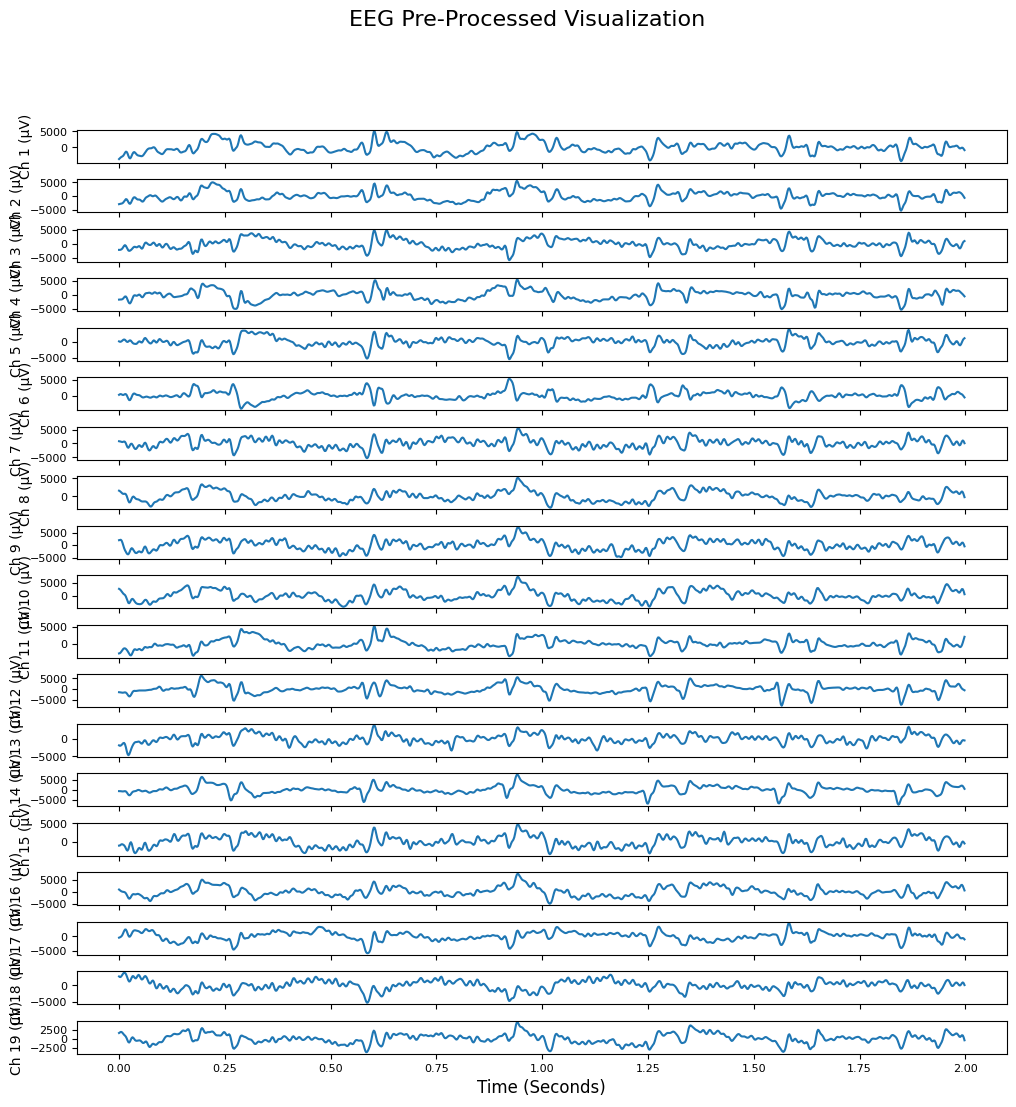

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration
start_sample_eeg = 43000
final_sample_eeg = 44000
n_samples = final_sample_eeg - start_sample_eeg  # Number of samples per channel
time = np.arange(n_samples) / fs  # Generate time vector
n_channels = 19  # Number of EEG channels

# Example: Simulated EEG Data (Replace with your actual preprocessed_eeg array)
# preprocessed_eeg = np.random.randn(1, n_channels, 100000)  # Uncomment for testing

# Create subplots for each channel
fig, axs = plt.subplots(n_channels, 1, figsize=(12, 12), sharex=True)
fig.subplots_adjust(hspace=0.5)  # Adjust spacing between plots

# Plot each channel
# Plot each channel
for channel in range(n_channels):
    axs[channel].plot(
        time,
        preprocessed_eeg[channel][start_sample_eeg:final_sample_eeg]  # Adjust indexing
    )
    axs[channel].set_ylabel(f'Ch {channel + 1} (μV)', fontsize=10)
    axs[channel].tick_params(axis='both', which='major', labelsize=8)


# Set xlabel and title
axs[-1].set_xlabel('Time (Seconds)', fontsize=12)
fig.suptitle('EEG Pre-Processed Visualization', fontsize=16)

# Show the plot
plt.show()


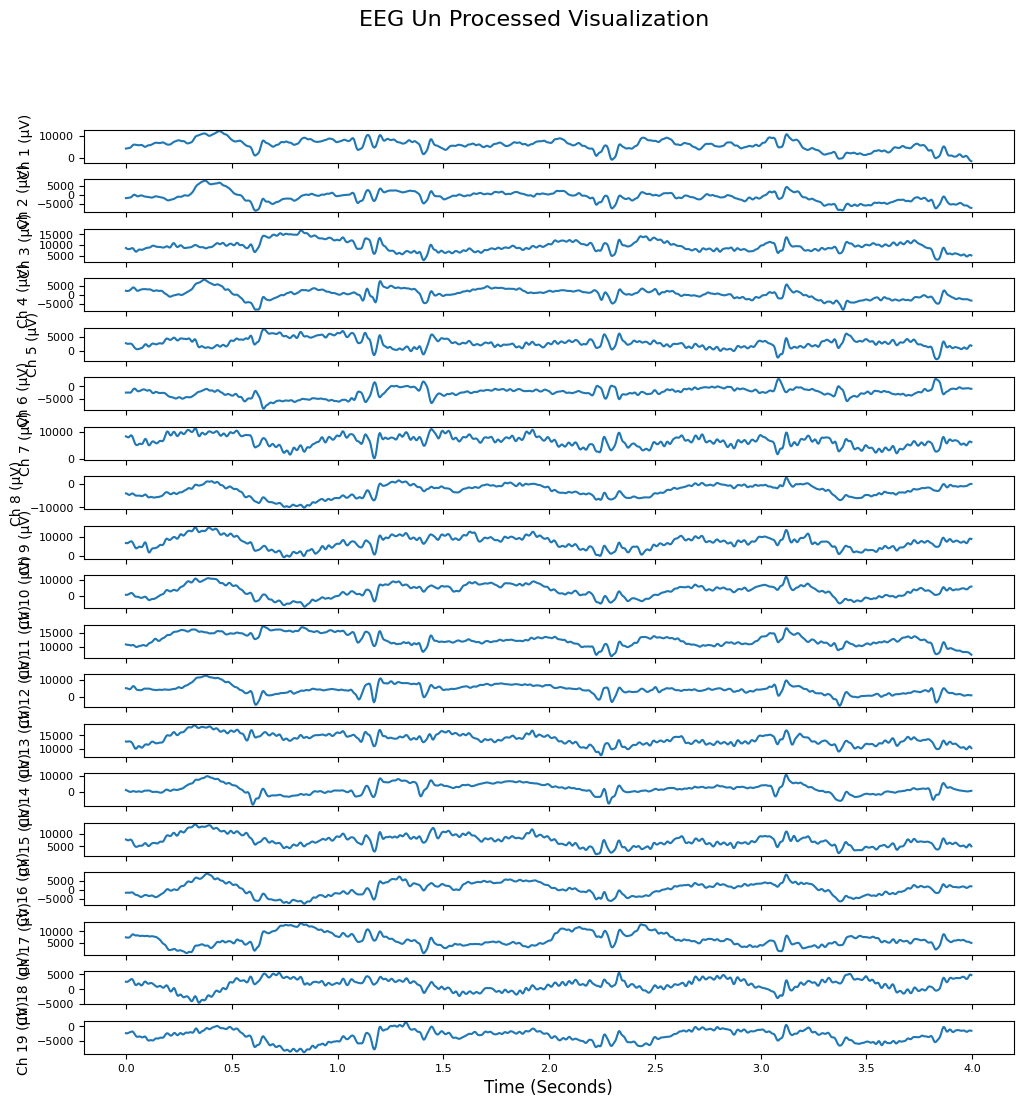

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration
start_sample_eeg = 42000
final_sample_eeg = 43000
fs_target = 250  # Target sampling frequency (adjust based on your data)
n_samples = final_sample_eeg - start_sample_eeg  # Number of samples per channel
time = np.arange(n_samples) / fs_target  # Generate time vector
n_channels = 19  # Number of EEG channels

# Example: Simulated EEG Data (Replace with your actual preprocessed_eeg array)
# preprocessed_eeg = np.random.randn(1, n_channels, 100000)  # Uncomment for testing

# Create subplots for each channel
fig, axs = plt.subplots(n_channels, 1, figsize=(12, 12), sharex=True)
fig.subplots_adjust(hspace=0.5)  # Adjust spacing between plots

# Plot each channel
for channel in range(n_channels):
    axs[channel].plot(
        time,
        loaded_eeg[channel][start_sample_eeg:final_sample_eeg]  # Adjust indexing
    )
    axs[channel].set_ylabel(f'Ch {channel + 1} (μV)', fontsize=10)
    axs[channel].tick_params(axis='both', which='major', labelsize=8)


# Set xlabel and title
axs[-1].set_xlabel('Time (Seconds)', fontsize=12)
fig.suptitle('EEG Un Processed Visualization', fontsize=16)

# Show the plot
plt.show()

In [ ]:
def convert_indices_to_index_ranges(indices, min_gap=2):
    """
    Group consecutive indices into [start, end] ranges.

    Parameters
    ----------
    indices : 1D array-like of sorted integer indices
    min_gap : int
        The minimum jump between successive indices to consider them "disconnected."
        If min_gap=2, then any pair of consecutive indices that differ by more than 1
        starts a new range.

    Returns
    -------
    ranges : np.ndarray
        2D array of shape (N, 2), where each row is [start_idx, end_idx].
    """
    if len(indices) == 0:
        return np.zeros((0, 2), dtype=int)

    ranges = []
    start_idx = indices[0]
    prev_idx = indices[0]

    for i in indices[1:]:
        # If there's a break in consecutive indices
        if (i - prev_idx) >= min_gap:
            # Close off the previous range
            ranges.append([start_idx, prev_idx])
            # Start a new range
            start_idx = i
        prev_idx = i

    # Close off the last range
    ranges.append([start_idx, prev_idx])

    return np.array(ranges, dtype=int)


In [ ]:
import numpy as np

def get_burst_ranges_cell(global_zs, bs_ranges):
    """
    Creates a list of burst ranges for each burst-suppression (BS) episode.

    Parameters
    ----------
    global_zs : np.ndarray
        1D array of length `num_samples`. 0 indicates suppression, 1 indicates burst.
    bs_ranges : np.ndarray
        2D array of shape (num_bs_episodes, 2). Each row is [start_index, end_index]
        for a burst-suppression episode.

    Returns
    -------
    burst_ranges_cell : list of np.ndarray
        A list where each element corresponds to a BS episode. 
        Each element is a 2D array of shape (num_bursts, 2) specifying start and end
        indices for bursts in that episode.
    """
    # Indices where global_zs == 1
    all_burst_indices = np.where(global_zs == 1)[0]

    num_bs = bs_ranges.shape[0]  # number of BS episodes
    burst_ranges_cell = []

    for k in range(num_bs):
        start_ind = bs_ranges[k, 0]
        end_ind   = bs_ranges[k, 1]

        # Get all bursts within the [start_ind, end_ind] interval
        mask = (all_burst_indices >= start_ind) & (all_burst_indices <= end_ind)
        burst_indices = all_burst_indices[mask]

        # Convert consecutive burst indices to [start, end] ranges
        burst_ranges = convert_indices_to_index_ranges(burst_indices, min_gap=2)

        burst_ranges_cell.append(burst_ranges)

    return burst_ranges_cell


In [ ]:
import numpy as np

def label_global_zs(data, srate):
    """
    Label each sample as burst (1) or suppression (0).

    Parameters
    ----------
    data : np.ndarray
        Shape (num_channels, num_samples)
    srate : float
        Sampling rate

    Returns
    -------
    global_zs : np.ndarray
        1D array of length num_samples (0 => suppression, 1 => burst).
    """
    num_chans, num_samps = data.shape
    global_zs = np.zeros(num_samps, dtype=int)

    # This is just an example threshold-based approach:
    # You must implement the real logic from your MATLAB code.
    for i in range(num_samps):
        # For example, maybe take the mean amplitude across channels at sample i
        val = np.mean(np.abs(data[:, i]))
        if val > SOME_THRESHOLD:
            global_zs[i] = 1
        else:
            global_zs[i] = 0

    return global_zs


In [ ]:
import numpy as np

def calculate_bsr(global_zs, srate, is_artifact):
    """
    Calculate the burst-suppression ratio (BSR) at each sample.

    Parameters
    ----------
    global_zs : np.ndarray
        1D array of length `num_samples` (0 => suppression, 1 => burst).
    srate : float
        Sampling rate (Hz).
    is_artifact : np.ndarray
        1D binary array of length `num_samples`, where 1 => artifact, 0 => valid.
    
    Returns
    -------
    bsr : np.ndarray
        1D array of length `num_samples`, giving the local fraction of suppression
        (global_zs == 0) around each sample (excluding artifacts).
    """

    window_duration = 2.0  # seconds, example
    window_size = int(np.round(window_duration * srate))

    num_samps = len(global_zs)
    bsr = np.zeros(num_samps, dtype=float)

    for i in range(num_samps):
        start_i = max(0, i - window_size // 2)
        end_i = min(num_samps, i + window_size // 2)

        # Exclude artifact
        valid_mask = (is_artifact[start_i:end_i] == 0)
        local_zs = global_zs[start_i:end_i][valid_mask]

        if len(local_zs) == 0:
            bsr[i] = 0.0
        else:
            # fraction of samples that are "suppression" (== 0)
            frac_supp = np.sum(local_zs == 0) / len(local_zs)
            bsr[i] = frac_supp

    return bsr


In [ ]:
def calculate_bs_index_ranges(bsr, srate):
    """
    Identify contiguous index ranges where the BSR indicates 
    burst-suppression (above some threshold).

    Parameters
    ----------
    bsr : np.ndarray
        1D array of floats in [0,1], of length `num_samples`.
    srate : float
        Sampling rate (not necessarily used if your threshold is direct)

    Returns
    -------
    bs_ranges : np.ndarray
        2D array of shape (N, 2) with [start_index, end_index] for each
        contiguous region identified as burst-suppression.
    """
    threshold = 0.5  # example
    is_bs = (bsr > threshold)

    bs_indices = np.where(is_bs)[0]
    # Re-use the convert_indices_to_index_ranges function, or implement the grouping logic.
    bs_ranges = convert_indices_to_index_ranges(bs_indices, min_gap=2)

    return bs_ranges


In [ ]:
def get_params(*args):
    """
    Return one or more DetectBsParams by name, similar to MATLAB's get_params method.
    
    Parameters
    ----------
    *args : str
        One or more parameter names (e.g., 'min_bs_time', 'forgetting_time', etc.)

    Returns
    -------
    A single value (if one parameter name is given) or a tuple of values (if multiple are given).

    Examples
    --------
    >>> min_bs_time = get_params('min_bs_time')
    >>> forgetting_time, burst_thresh = get_params('forgetting_time', 'burst_threshold')
    """
    # Dictionary of parameter names and their values
    params_dict = {
        # %% Params for labeling z's (burst vs suppression)
        # Local z's labeling
        'forgetting_time':       0.1047,  # controls how much of recursive mean/variance is based on past
        'burst_threshold':       1.75,    # min variance for sample to be considered a burst

        # Combining z's from local to global
        'agree_percent':         0.6,     # fraction of channels needing to agree on a '1' 
        'min_suppression_time':  0.5,     # minimum duration (secs) of a suppression

        # %% Params for BSR
        'bsr_low_cutoff':        0.5,
        'bsr_high_cutoff':       1.0,
        'bsr_window':            60,      # window length in seconds for smoothing used to calculate BSR

        # %% Params for getting BS episodes from BSR
        'min_bs_time':           10 * 60, # minimum duration (secs) of a BS episode considered
        'bs_episode_smoothing_amount': 60 # max gap (secs) between episodes to consider as continuous
    }

    # Collect requested parameters
    results = []
    for arg in args:
        if arg not in params_dict:
            raise KeyError(f"Unknown parameter '{arg}' requested. Check get_params dictionary.")
        results.append(params_dict[arg])

    # Return a single value if only one parameter was requested, otherwise a tuple
    if len(results) == 1:
        return results[0]
    else:
        return tuple(results)


In [ ]:
def detect_bs(eeg, is_artifact):
    data = eeg['data']    # shape (num_channels, num_samples)
    srate = eeg['srate']

    # 1) Identify bursts vs. suppression at each sample
    global_zs = label_global_zs(data, srate)

    # 2) Compute burst-suppression ratio
    bsr = calculate_bsr(global_zs, srate, is_artifact)

    # 3) Identify contiguous burst-suppression episodes
    bs_ranges = calculate_bs_index_ranges(bsr, srate)

    # 4) Enforce minimum BS episode length
    min_bs_time = get_params('min_bs_time') 
    min_bs_slength = int(min_bs_time * srate)

    # Filter out short episodes
    filtered_bs = []
    for rng in bs_ranges:
        if (rng[1] - rng[0]) >= min_bs_slength:
            filtered_bs.append(rng)
    bs_ranges = np.array(filtered_bs)

    # 5) Build the list of burst-range blocks
    burst_ranges_cell = get_burst_ranges_cell(global_zs, bs_ranges)

    return bs_ranges, global_zs, bsr, burst_ranges_cell
